<a href="https://colab.research.google.com/github/CVH4OYC/computervision/blob/main/LR_3_Residual_Connection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
from torchvision import datasets

In [3]:
download_dir = "./dataset"

# Скачиваем обучающую выборку.
train_data = datasets.CIFAR100(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку.
val_data = datasets.CIFAR100(root=download_dir, download=True, train=False)

100%|██████████| 169001437/169001437 [00:08<00:00, 20673701.59it/s]


Extracting ./dataset/cifar-100-python.tar.gz to ./dataset
Files already downloaded and verified


In [8]:
# Объекты данных из обучающей выборки (50 000 цветных картинок размера 32 x 32).
x_train = torch.tensor(train_data.data).permute(0, 3, 1, 2).float() / 255.
x_train.shape

torch.Size([50000, 3, 32, 32])

In [9]:
# Предсказываемые величины для обучающей выборки (50 000 чисел от 0 до 99).
y_train = torch.tensor(train_data.targets)

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")

torch.Size([50000])
tensor(0)
tensor(99)


In [6]:
# Сопоставление численных значений
#  (индексов в списке classes) реальным классам.
classes = train_data.classes
classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [10]:
# Аналогично записываем x и y для валидационной выборки (10 000 примеров).
x_val = torch.tensor(val_data.data).permute(0, 3, 1, 2).float() / 255.
y_val = torch.tensor(val_data.targets)

print(x_val.shape, y_val.shape, sep="\n")

torch.Size([10000, 3, 32, 32])
torch.Size([10000])


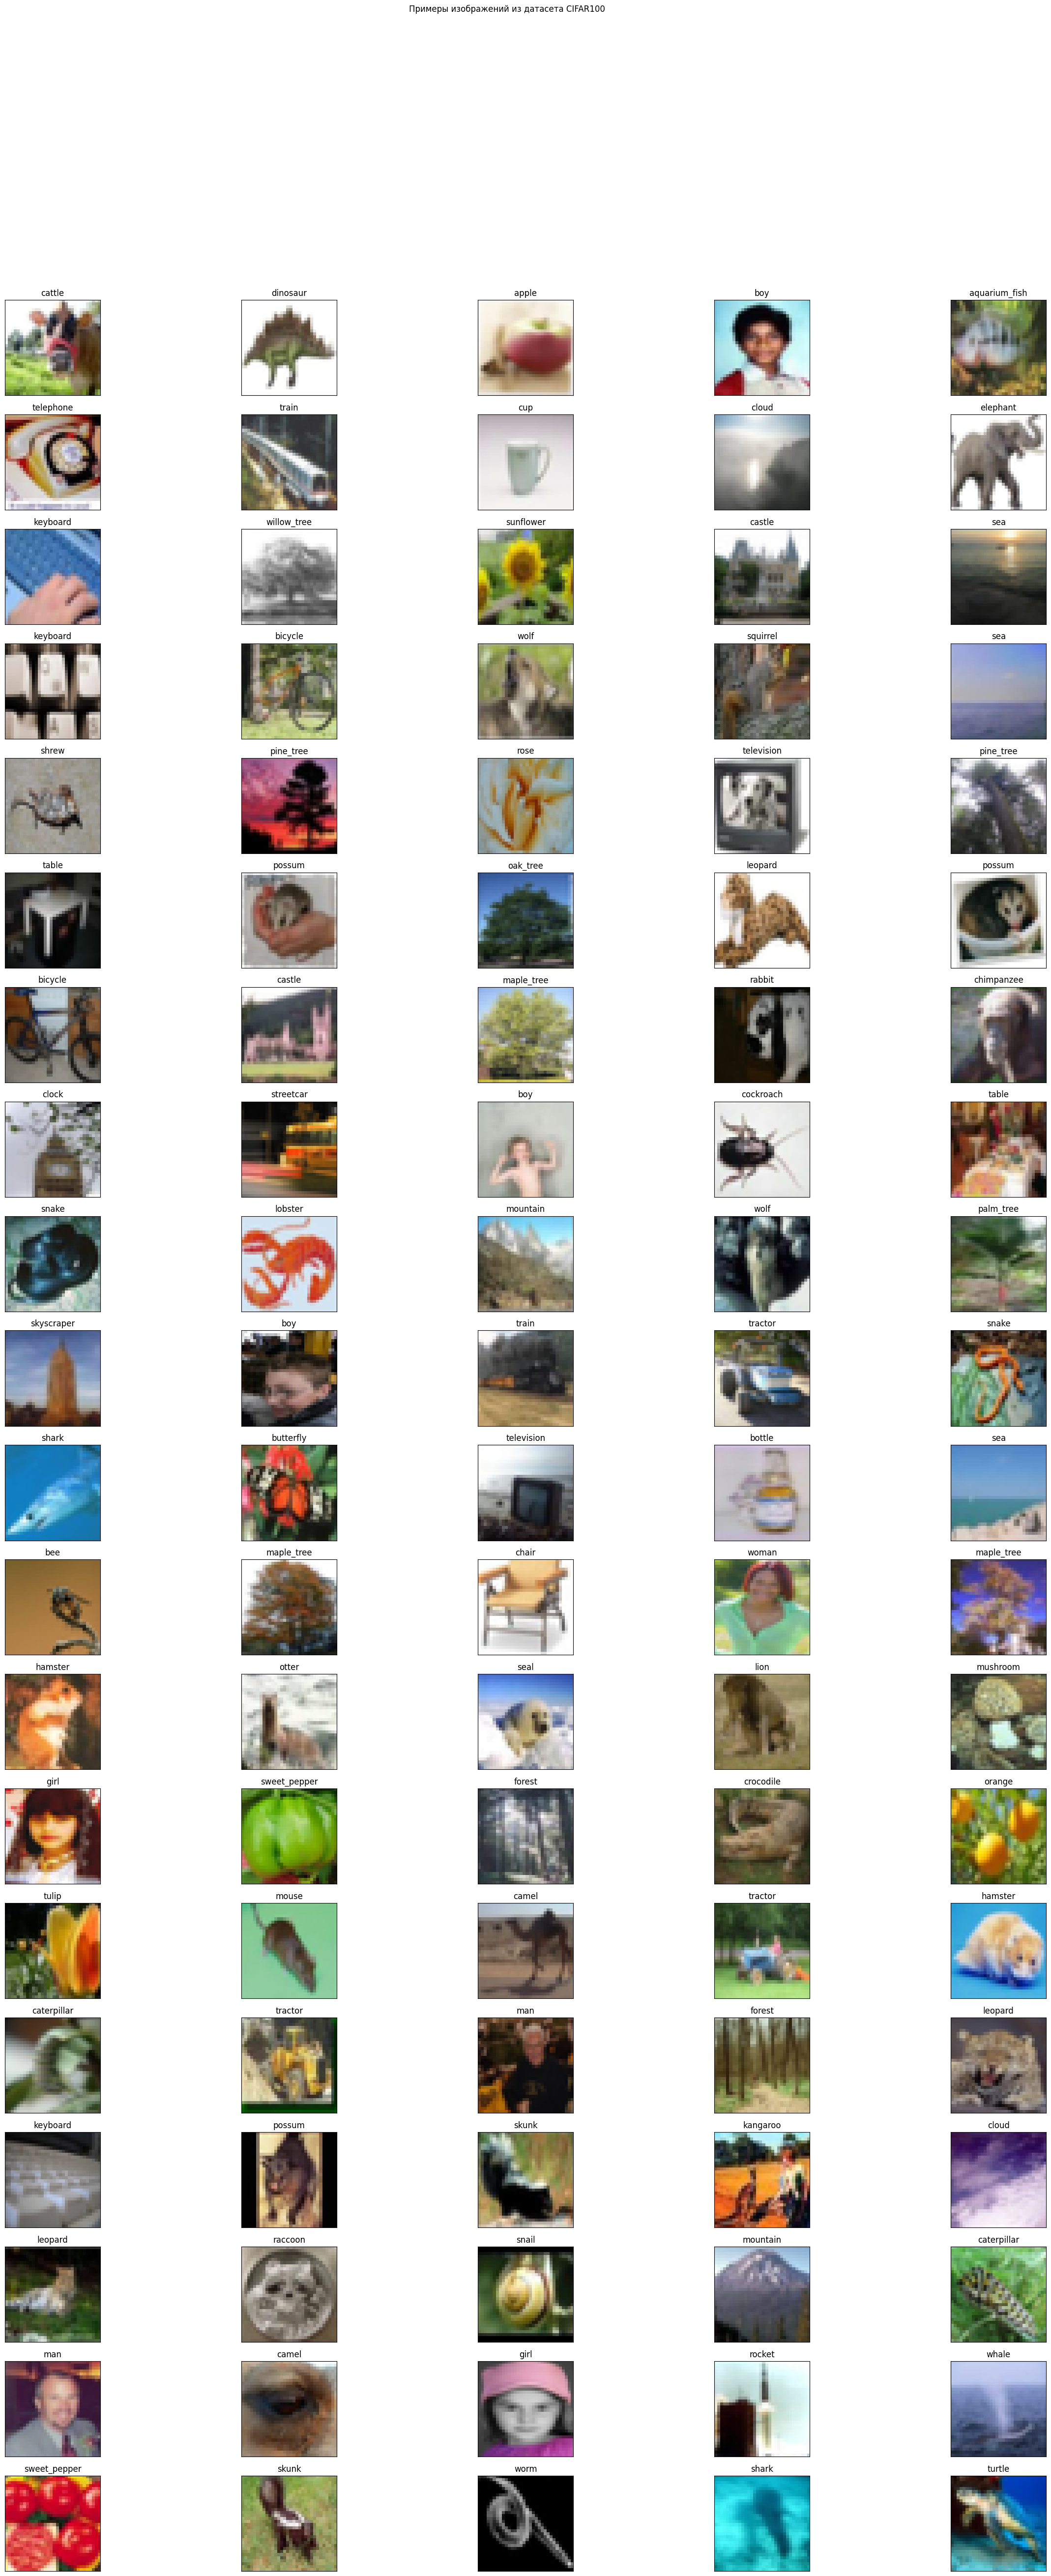

In [12]:
# Посмотрим на то, как выглядят картинки из датасета.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 20
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 3 * hh))
fig.suptitle("Примеры изображений из датасета CIFAR100")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    img = x.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[y])
plt.show()

In [14]:
# проверяем, что у нас вещественные числа
print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")

tensor(0.)
tensor(1.)
torch.float32


In [15]:
import torch

class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.ReLU,  # Класс функции активации.
        padding_mode='zeros'       # Режим паддинга (по умолчанию - заполнение нулями).
    ):
        super().__init__()

        # Функция активации для нелинейности.
        self.activation = activation()

        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        padding_size = kernel_size // 2

        # Операция свёртки.
        # Создаём сверточный слой с указанием количества каналов,
        # размера ядра, паддинга и режима паддинга.
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode=padding_mode
        )

        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c:
            # То делаем свёртку с ядром размера 1 для изменения числа каналов.
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
                padding=0  # Ядро 1x1 не требует паддинга
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # Прямой проход через свертку и остаточную связь.
        return self.activation(self.conv(x) + self.correct_channels(x))


In [25]:
class LeNet5Residual(torch.nn.Module):
    def __init__(self):
        super(LeNet5Residual, self).__init__()

        # Первый ResidualBlock заменяет первую конволюцию
        self.res_block1 = ResidualBlock(input_c=3, output_c=32, kernel_size=5)
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        # Второй ResidualBlock заменяет вторую конволюцию
        self.res_block2 = ResidualBlock(input_c=32, output_c=64, kernel_size=5)
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()

        # Полносвязные слои
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 120)
        self.act1 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(120, 84)
        self.act2 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(84, 100)

    def forward(self, x):
        x = self.res_block1(x)
        x = self.pool1(x)

        x = self.res_block2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)

        return x


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

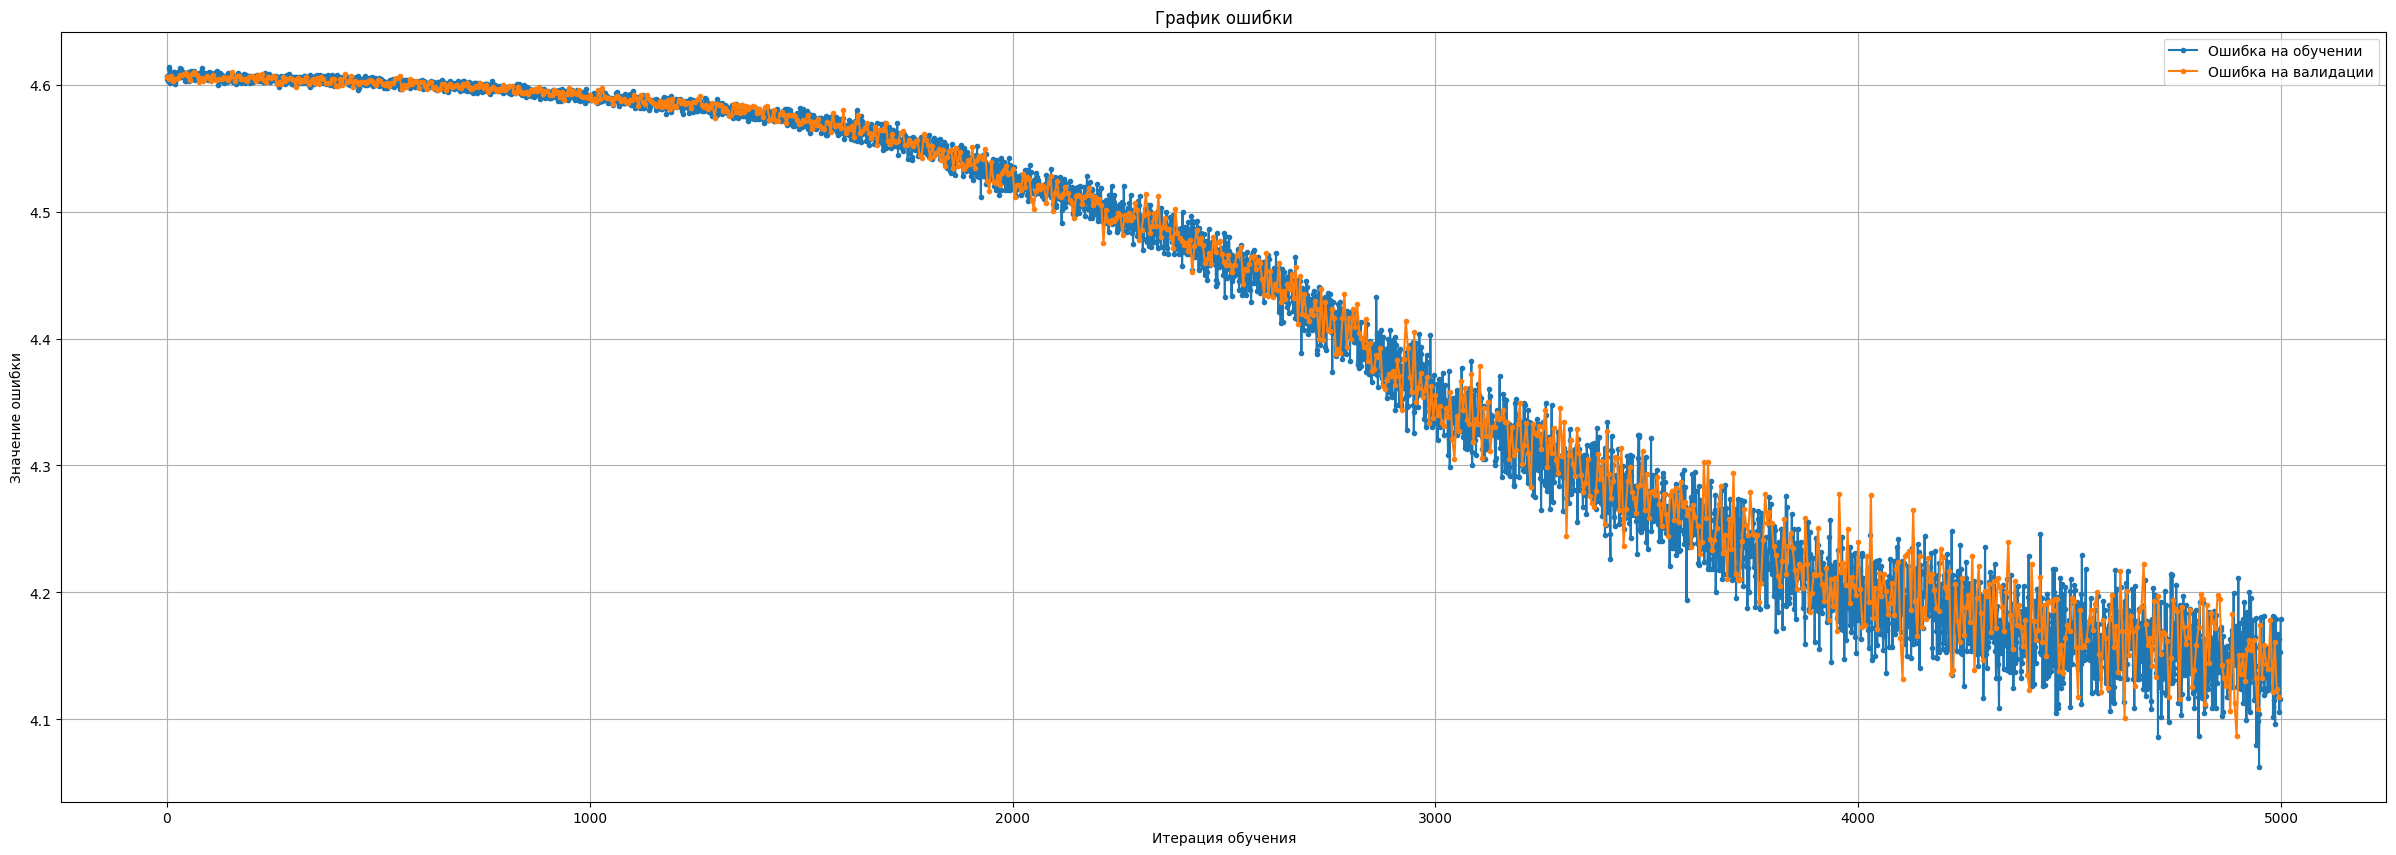

In [26]:
# Реализуем цикл обучения модели.

from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера
#  или виртуальной машины, если есть такая возможность.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = LeNet5Residual().to(dtype=x_train.dtype, device=device)  # Важно, чтобы все тензоры были одного типа и на одном устройстве.

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.CrossEntropyLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Будем на каждой итерации обучения брать не все 50 000 картинок,
    #  а лишь случайные batch_size из них.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    pred = model(x_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

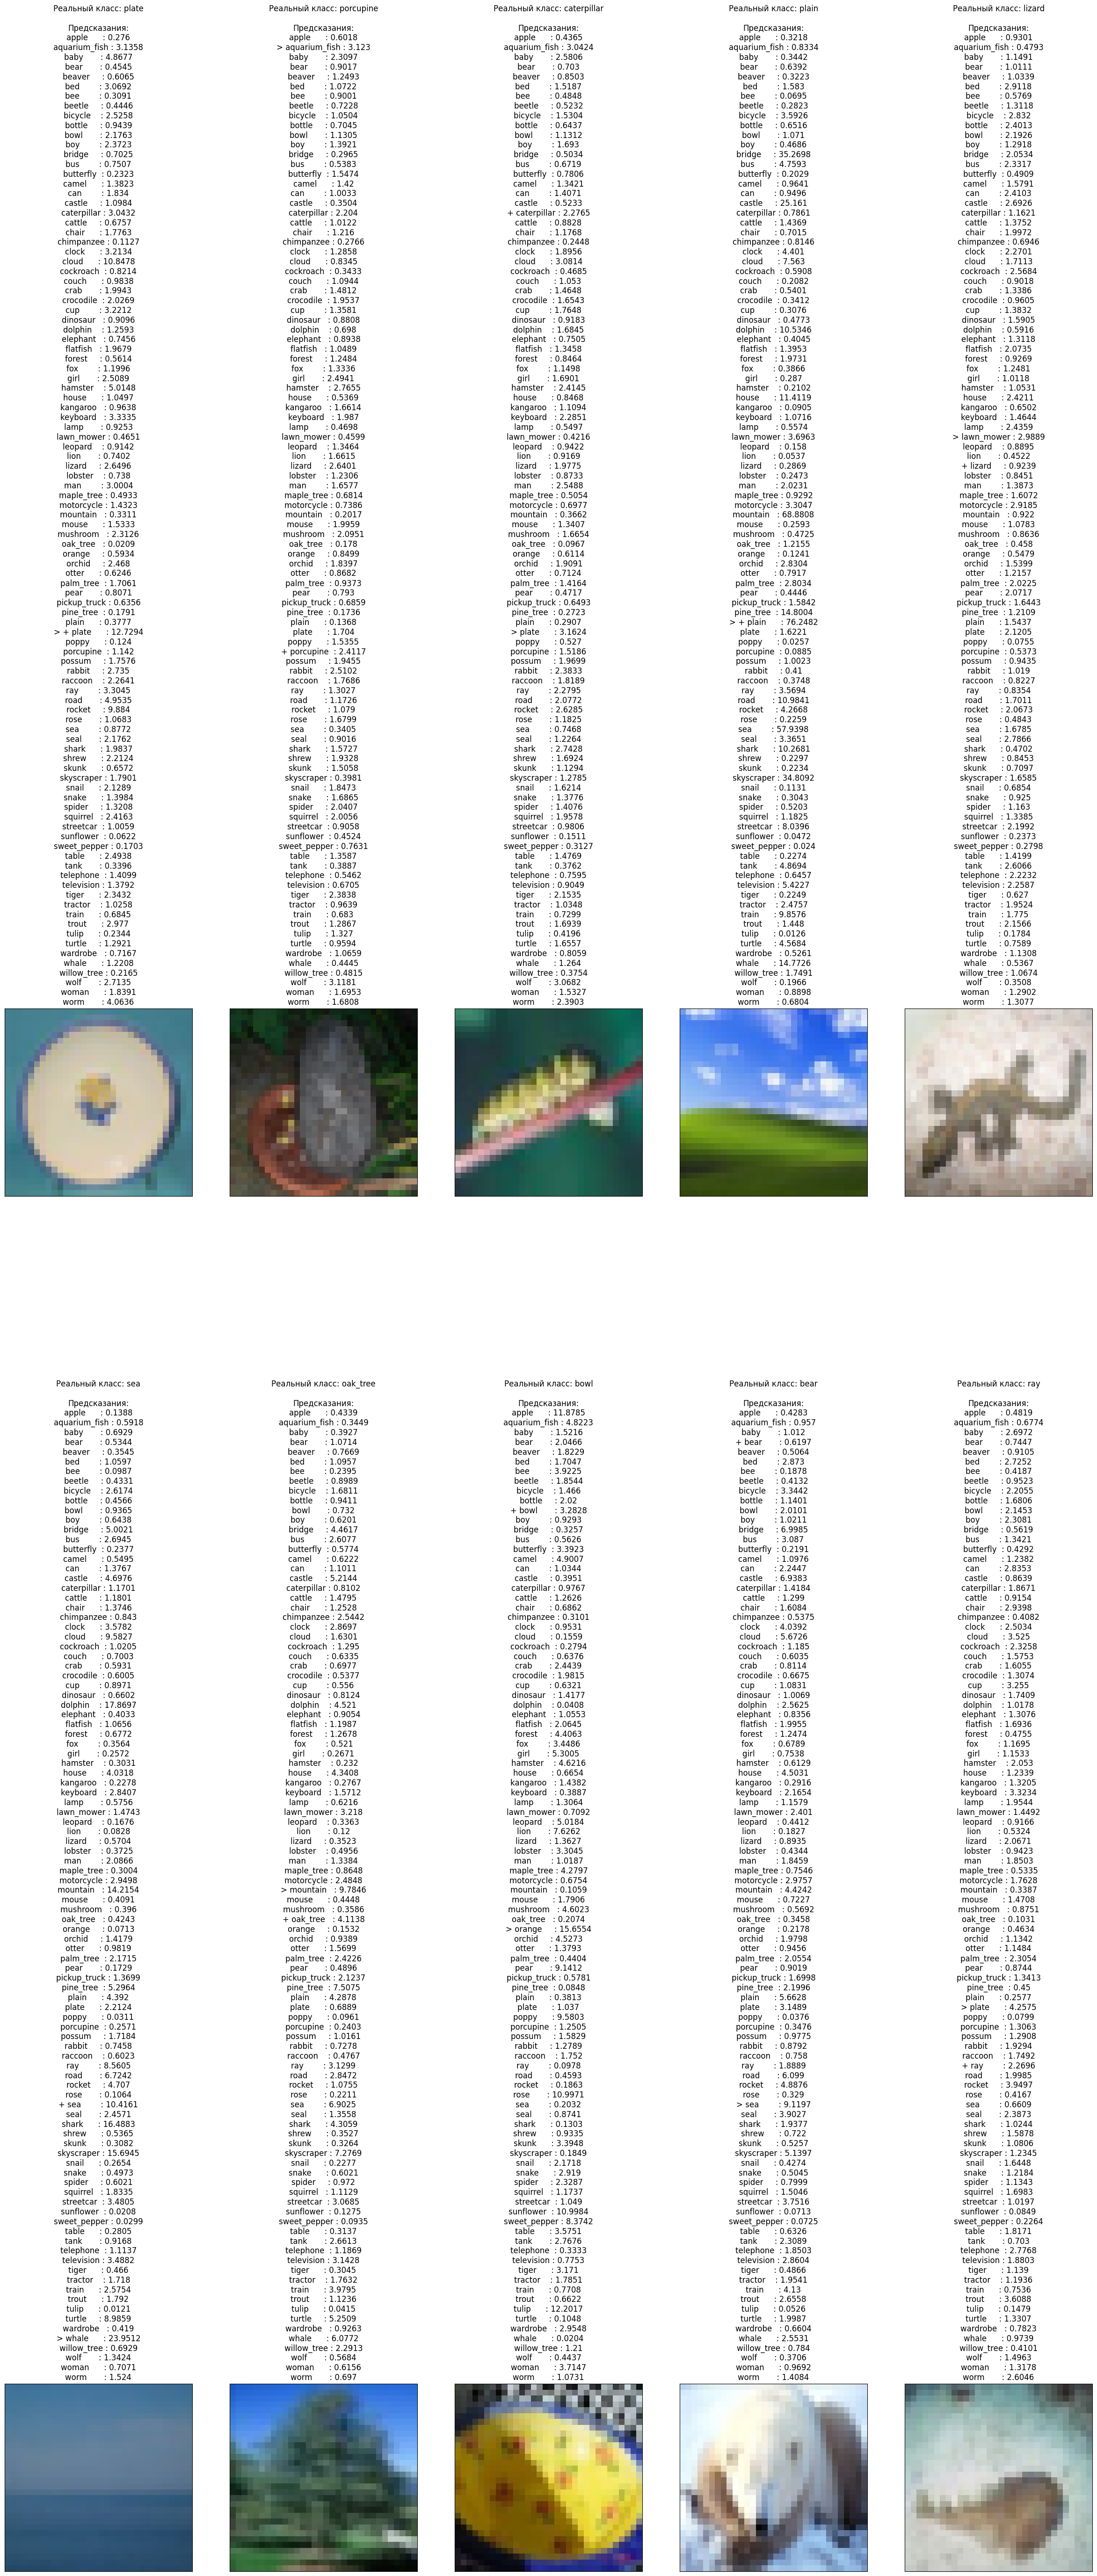

In [34]:
import random
import numpy as np
import matplotlib.pyplot as plt

def show_results(model, h=2, w=5):
    with torch.no_grad():
        # Генерируем случайные индексы
        random_indices = random.sample(range(x_val.shape[0]), h * w)
        batch_probs = model(x_val[random_indices].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 35 * h))
        for i in range(h * w):
            plt.subplot(h, w, i + 1)

            # Извлекаем изображение
            img = x_val[random_indices[i]].cpu().numpy().transpose(1, 2, 0)


            plt.imshow(img)  # (H, W, C)

            title = f'Реальный класс: {classes[y_val[random_indices[i]]]}'
            title += '\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[random_indices[i]] else "+ ",
                    classes[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])  # Скрыть метки по оси X
            plt.yticks([])  # Скрыть метки по оси Y
        plt.show()

show_results(model)


Целых два верных предсказания для 10 случайных картинок (скорее всего связано с тем, что очень много классов)